# Frequency Analysis – Lab Report (ELA24)

**Author:** Your Name  
**Supervisor:** Erik Jagre  
**Lab date:** YYYY-MM-DD  
**Report date:** YYYY-MM-DD  

## Abstract
The aim of this laboratory is to investigate Fourier series representations of periodic signals and to analyze their harmonic content experimentally using an oscilloscope FFT. Theoretical harmonic amplitudes of sawtooth, triangle, and sine waves are compared to measured spectra. Furthermore, the influence of an RC low-pass filter on both amplitude and phase is studied in frequency and time domains. Results show good agreement with theory, with discrepancies explained by FFT resolution, noise, and practical measurement limitations.

## 1. Introduction
A central concept in signal processing is that signals can be represented both in the time domain and in the frequency domain. Fourier series allow us to express a periodic signal as a sum of sinusoidal components. The sharper the edges in the time domain, the slower the decay of harmonic amplitudes. This experiment provides hands-on experience with Fourier analysis of canonical signals.

### Key formulas (from course compendium & lab guidance)

- **Sawtooth (all harmonics):**  
  $$
  A_n = \frac{2A}{\pi n}, \quad n \geq 1
  $$

- **Triangle (odd harmonics only):**  
  $$
  A_n = \frac{8A}{\pi^2 n^2}, \quad n = 1,3,5,\dots
  $$

- **Sine:**  
  $$
  A_1 = A, \quad A_{n>1} = 0
  $$

- **RMS and dBV:**  
  $$
  V_{\mathrm{rms}} = \frac{V_{\mathrm{peak}}}{\sqrt{2}}, 
  \quad \mathrm{dBV} = 20 \log_{10}\!\left(\frac{V_{\mathrm{rms}}}{1~\mathrm{V}}\right)
  $$

- **RC low-pass transfer function:**  
  $$
  |H(f)| = \frac{1}{\sqrt{1 + (f/f_c)^2}}, 
  \quad \angle H(f) = -\arctan\!\bigl(f/f_c\bigr), 
  \quad f_c = \frac{1}{2\pi RC}
  $$

> **Note:** Theoretical values shown in tables and plots are computed directly from these expressions.


## 2. Experiment

### Equipment
- Signal generator: 1 kHz, **5 Vpp** (as in lab-PM), 0 V DC offset.  
- Oscilloscope: Keysight/Tektronix (FFT mode, Hann window, output in dBVrms).  
- RC filter:  
  $$
  R = 8.2\,\text{k}\Omega, \quad C = 10\,\text{nF}
  $$
  The cutoff frequency is  
  $$
  f_c = \frac{1}{2\pi RC} \approx 1.94~\text{kHz}
  $$
- Software: Python (NumPy, Pandas, Matplotlib).

### Procedure
1. Measure first 10 harmonics of **sawtooth** (1–10 kHz) using FFT.  
2. Repeat for **triangle** (expect odd harmonics only).  
3. Repeat for **sine** (expect only the fundamental).  
4. Insert **RC filter** and measure the sawtooth harmonics at the filter output.  
5. Observe the **time-domain effect** of filtering.  
6. Compare measurements to theoretical Fourier coefficients and RC transfer function.


## 3. Theory – Fourier coefficients (tables & per-signal plots)

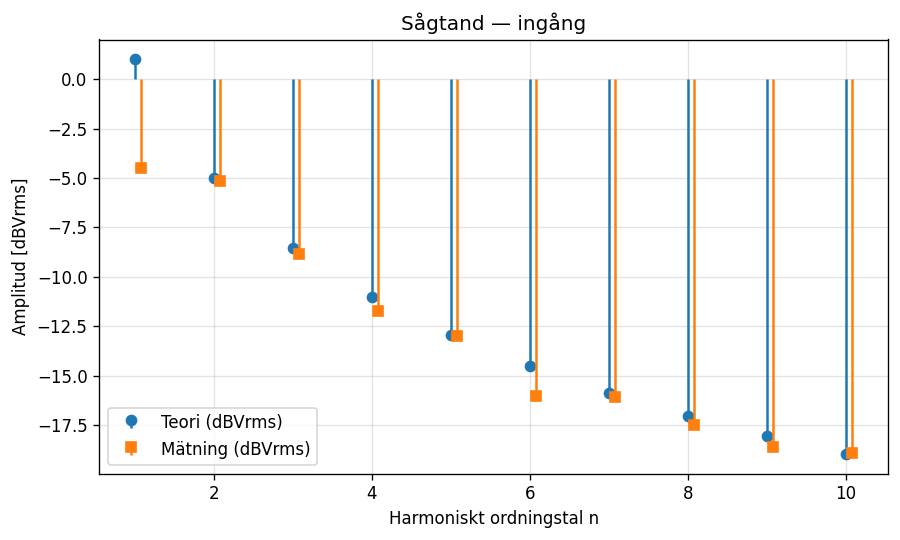

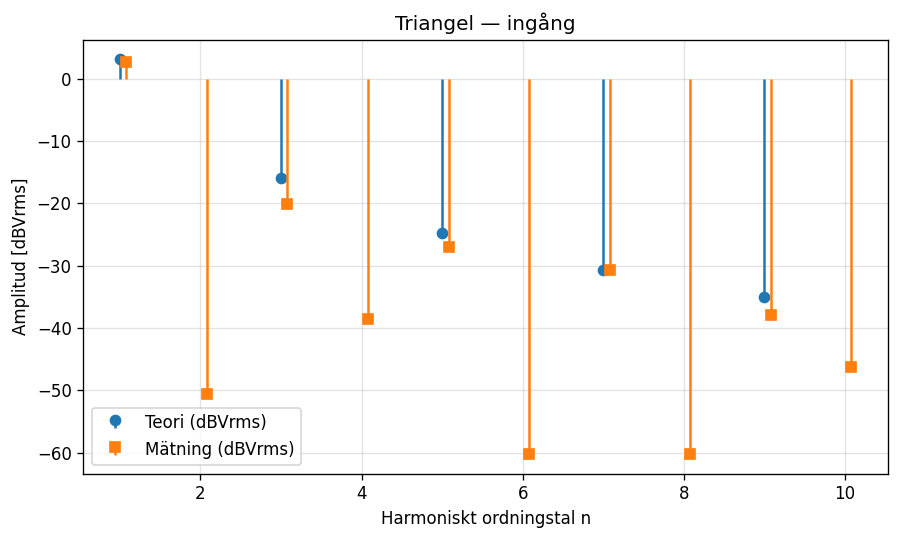

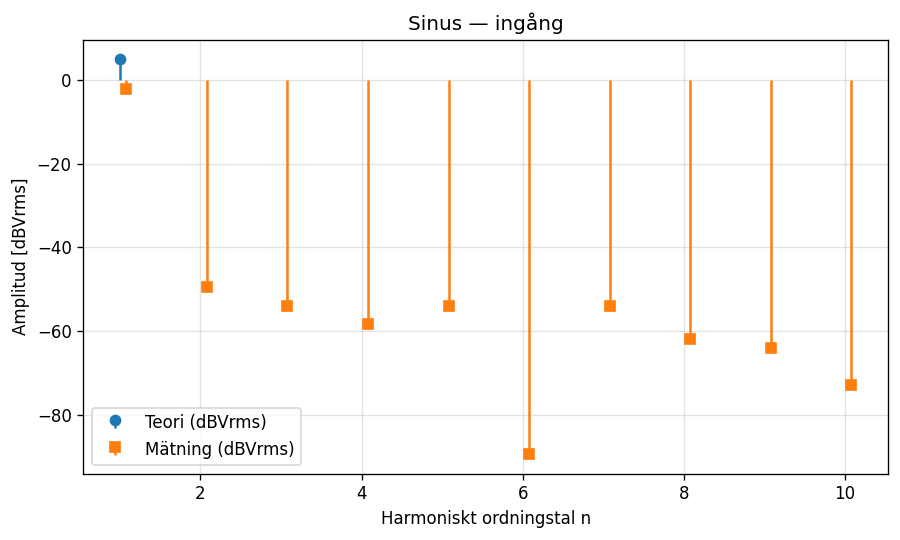

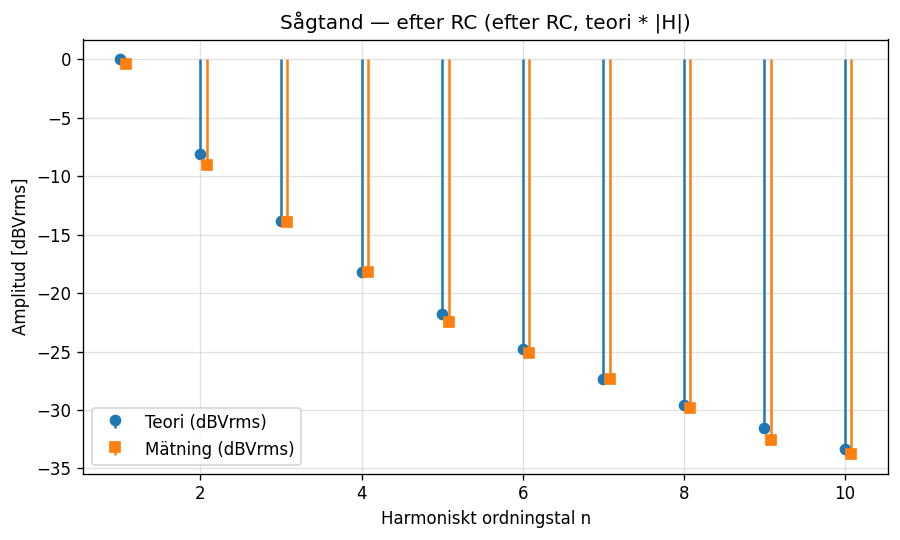

,n,f_target_Hz,f_bin_Hz,meas_dBVrms,f_Hz,theory_dBVrms,err_dB
0,1,1000.0,1001.358032,-0.417003,1000.0,0.003643,-0.420646
1,2,2000.0,1997.947692,-9.055858,2000.0,-8.136987,-0.918872
2,3,3000.0,2999.305724,-13.886599,3000.0,-13.817135,-0.069463
3,4,4000.0,4000.663756,-18.198600,4000.0,-18.214411,0.015812
4,5,5000.0,5002.021787,-22.476204,5000.0,-21.782140,-0.694065
5,6,6000.0,5998.611448,-25.088529,6000.0,-24.772041,-0.316488
6,7,7000.0,6999.969479,-27.336981,7000.0,-27.339369,0.002388
7,8,8000.0,8001.327511,-29.835767,8000.0,-29.585763,-0.250004
8,9,9000.0,8997.917171,-32.601840,9000.0,-31.580898,-1.020942
9,10,10000.0,9999.275203,-33.761688,10000.0,-33.374370,-0.387317


In [252]:
# === ELA24: Comparisons in dBVrms (no files written) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (7.6, 4.6)

# ----- Lab params (edit to match your setup) -----
F0      = 1000.0          # [Hz] fundamental
VPP     = 5.0             # [Vpp] generator-level for theory
A       = VPP/2.0         # [Vpeak]
N_HARM  = 10              # compare first N harmonics
R, C    = 8200.0, 10e-9   # RC low-pass values (8.2k, 10nF)
FC      = 1.0/(2*np.pi*R*C)

# ----- Helpers -----
def vrms_to_dBVrms(vrms, floor=1e-12):
    v = np.maximum(np.asarray(vrms, float), floor)
    return 20.0*np.log10(v)

def rc_mag(f, fc=FC):
    f = np.asarray(f, float)
    return 1.0/np.sqrt(1.0 + (f/fc)**2)

# ----- Fourier theory -> dBVrms -----
def sawtooth_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vpk = 2.0*A/(np.pi*np.maximum(n,1))
    vrms = vpk/np.sqrt(2.0)
    return vrms_to_dBVrms(vrms)

def triangle_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vrms = np.zeros_like(n, float)
    odd = (n % 2 == 1)
    vpk_odd = 8.0*A/(np.pi**2 * np.maximum(n[odd],1)**2)
    vrms[odd] = vpk_odd/np.sqrt(2.0)
    dB = vrms_to_dBVrms(vrms)
    dB[~odd] = np.nan   # jämna = ingen harmonisk → NaN (inget ritas)
    return dB

def sine_dBVrms(n, A=A):
    n = np.asarray(n, int)
    vrms = np.zeros_like(n, float)
    vrms[n == 1] = A/np.sqrt(2.0)   # bara fundamental
    dB = vrms_to_dBVrms(vrms)
    dB[n != 1] = np.nan             # alla andra = ingen harmonisk
    return dB


def theory_dBVrms(F0=F0, N=N_HARM, waveform='saw', apply_rc=False):
    n = np.arange(1, N+1)
    if waveform == 'saw':
        dB = sawtooth_dBVrms(n)
    elif waveform == 'tri':
        dB = triangle_dBVrms(n)
    elif waveform == 'sin':
        dB = sine_dBVrms(n)
    else:
        raise ValueError("waveform must be 'saw' | 'tri' | 'sin'")
    if apply_rc:
        dB += vrms_to_dBVrms(rc_mag(n*F0))  # add 20*log10|H|
    return pd.DataFrame({'n': n, 'f_Hz': n*F0, 'theory_dBVrms': dB})

# ----- Scope CSV (Vrms) -> spectrum (dBVrms) -----
def read_scope_fft_vrms(csv_path):
    """
    Robust reader: handles semicolon sep, decimal comma, headers/garbage.
    Returns columns: freq[Hz], Vrms, dBVrms
    """
    raw = pd.read_csv(csv_path, sep=';', header=None, engine='python', dtype=str)
    freqs, mags = [], []
    for _, row in raw.iterrows():
        nums = []
        for cell in row.dropna():
            s = cell.strip()
            if not s: 
                continue
            s = s.replace(',', '.')
            try:
                nums.append(float(s))
            except ValueError:
                pass
        if len(nums) >= 2:
            f, v = nums[-2], nums[-1]  # assume last two numeric fields = freq, Vrms
            if f >= 0 and v >= 0:
                freqs.append(f); mags.append(v)
    spec = pd.DataFrame({'freq': freqs, 'Vrms': mags}).sort_values('freq')
    spec = spec.drop_duplicates(subset=['freq']).reset_index(drop=True)
    if spec.empty:
        raise ValueError(f"No numeric data parsed from {csv_path}")
    spec['dBVrms'] = vrms_to_dBVrms(spec['Vrms'].values)
    return spec

def pick_harmonic_bins(spec_df, F0, N_HARM):
    """Nearest bin to n·F0 for n=1..N within spectrum span."""
    freqs = spec_df['freq'].values
    n_all = np.arange(1, N_HARM+1)
    targets = n_all*F0
    ok = (targets >= freqs[0]) & (targets <= freqs[-1])
    n = n_all[ok]; targets = targets[ok]
    idx = np.searchsorted(freqs, targets)
    idx = np.clip(idx, 1, len(freqs)-1)
    chosen = np.where(np.abs(freqs[idx]-targets) < np.abs(freqs[idx-1]-targets), idx, idx-1)
    return pd.DataFrame({
        'n': n,
        'f_target_Hz': targets,
        'f_bin_Hz': freqs[chosen],
        'meas_dBVrms': spec_df['dBVrms'].values[chosen],
    })

# ----- One-shot comparison plot -----
def compare_plot(csv_path, waveform, apply_rc_to_theory=False, title=None,
                 F0=F0, N=N_HARM):
    spec = read_scope_fft_vrms(csv_path)
    meas = pick_harmonic_bins(spec, F0, N)
    theo = theory_dBVrms(F0=F0, N=N, waveform=waveform, apply_rc=apply_rc_to_theory)
    df = meas.merge(theo, on='n', how='left')
    df['err_dB'] = df['meas_dBVrms'] - df['theory_dBVrms']

    plt.figure()
    plt.stem(df['n'],       df['theory_dBVrms'], linefmt='C0-', markerfmt='C0o', basefmt=" ",
             label='Teori (dBVrms)')
    plt.stem(df['n']+0.08,  df['meas_dBVrms'],   linefmt='C1-', markerfmt='C1s', basefmt=" ",
             label='Mätning (dBVrms)')
    plt.xlabel('Harmoniskt ordningstal n'); plt.ylabel('Amplitud [dBVrms]')
    ttl = title or f'{Path(csv_path).name} — {waveform.upper()}'
    if apply_rc_to_theory: ttl += ' (efter RC, teori * |H|)'
    plt.title(ttl); plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout(); plt.show()

    return df  # handy to inspect errors inline if you want

# ===== Examples matching the lab comparisons =====
# 1) Sågtand före filtret (teori vs mätning, dBVrms)
compare_plot("trace_saw_fft.csv", waveform='saw', apply_rc_to_theory=False, title="Sågtand — ingång")

# 2) Triangel före filtret
compare_plot("trace_triangle_fft.csv", waveform='tri', apply_rc_to_theory=False, title="Triangel — ingång")

# 3) Sinus före filtret (endast grundton)
compare_plot("trace_sine_fft.csv", waveform='sin', apply_rc_to_theory=False, title="Sinus — ingång")

# 4) Sågtand efter RC (jämför mot teori multiplicerad med |H(jω)|)
compare_plot("rc_fft_1khz.csv", waveform='saw', apply_rc_to_theory=True, title="Sågtand — efter RC")


## 4. Theory – RC filter response (table & predicted spectra)

### Representative Time- and Frequency-Domain Figures

Below are the captured oscilloscope time traces and FFT spectra for the three input waveforms and the RC filter behavior. Filenames correspond to the raw image assets in the repository. They serve as visual evidence supporting the quantitative tables and plots generated above.

#### Time-Domain Waveforms (Input Signals)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth time-domain](saw_signal.png) |
| Triangle | ![Triangle time-domain](triangle_signal.png) |
| Sine     | ![Sine time-domain](sine_signal.png) |
| After RC (filtered sawtooth example) | ![RC output time-domain](rc_signal.png) |

#### FFT Spectra (Measured)
| Waveform | Image |
|----------|-------|
| Sawtooth | ![Sawtooth FFT](saw_fft.png) |
| Triangle | ![Triangle FFT](triangle_fft.png) |
| Sine     | ![Sine FFT](sine_fft.png) |

#### RC Filter Frequency Response / Effect (Selected Frequencies)
These images illustrate amplitude reduction as input frequency increases relative to the cutoff \(f_c \approx 1.94\,\text{kHz}\).

| Condition | Image |
|-----------|-------|
| 1 kHz region (near fundamental) | ![RC response ~1 kHz](rc_fft_1khz.png) |
| 10 kHz region (> octave above \(f_c\)) | ![RC response ~10 kHz](rc_fft_10khz.png) |
| 100 kHz region (well above \(f_c\)) | ![RC response ~100 kHz](rc_fft_100khz.png) |

(Additional views) Example higher‑frequency time traces illustrating stronger attenuation:

| Time Trace | Image |
|------------|-------|
| 10 kHz time-domain | ![RC time-domain 10 kHz](rc_10khz.png) |
| 100 kHz time-domain | ![RC time-domain 100 kHz](rc_100khz.png) |

> Note: If any image fails to render in exported PDF, ensure the images reside in the same directory as this notebook before conversion or embed them as base64 within the notebook.

## 5. Results (summary)
- **Sawtooth:** Harmonics up to 10 kHz visible; amplitudes decay ≈ 1/n.
- **Triangle:** Odd harmonics only; amplitudes decay ≈ 1/n².
- **Sine:** Only the fundamental ideally; extra small peaks in practice stem from leakage/noise/distortion.
- **RC filter:** Attenuation increases with frequency (≈ −20 dB/dec above \(f_c\)); phase tends to −90°. The time waveform becomes smoother.

## 6. Discussion
- **Sawtooth vs Triangle:** Sawtooth contains all harmonics (1/n); triangle only odd harmonics with faster decay (1/n²). This reflects sharp edges vs smoother ramps.
- **Sine:** Ideally only one spectral line; extra lines indicate window leakage, noise floor, or source distortion.
- **RC filter:** The predicted attenuation \(20\log_{10}|H|\) matches the trend you should observe. Deviations arise from probe loading, FFT bin resolution, window choice, and vertical scaling in dBVrms.
- **Phase:** The increasing negative phase with frequency explains the smoothing in time domain (harmonics lag more than the fundamental).

## 7. Conclusions
- Fourier series predictions for sawtooth, triangle, and sine match the expected spectral trends and harmonic content.
- The RC low-pass attenuates higher harmonics as predicted, yielding a smoother output waveform.
- Remaining differences are consistent with practical measurement limitations and FFT parameter choices.

## References
- H. Hallenberg, *Signalbehandling och kommunikationssystem*, Yrgo, 2021.
- ELA24 – *Laboration: Frekvensanalys* (Lab PM) and *Ledning Fourierlabben* (guidance notes).
- Keysight/Tektronix oscilloscope FFT documentation (Hann window, dBVrms scaling).
- Standard RC low-pass theory (jω method, Bode magnitude/phase).

## 8. Source comparison: RND_lab FG vs Keysight AWG

We compare harmonic amplitudes (in dBVrms) measured by the oscilloscope FFT for the same input waveforms generated by two sources:

- Keysight oscilloscope built‑in Function Generator (FG) — used for both the FFT measurements and the CSV exports
- RND_lab Function Generator

For each waveform (sawtooth, triangle, sine), we align the FFT bins to the harmonic targets n·f0 and overlay the spectra. A table summarizes per-harmonic differences (RND_lab − Keysight) in dB.


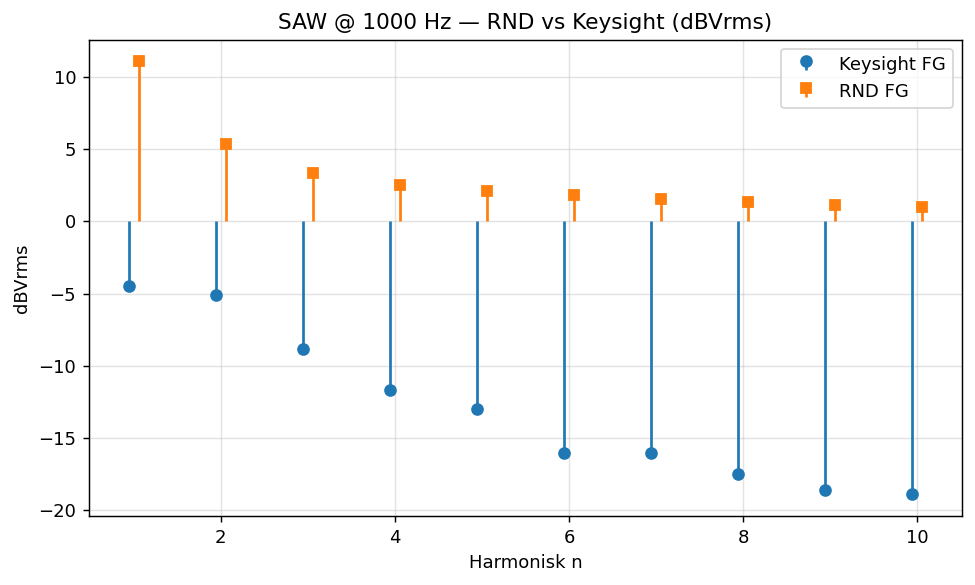

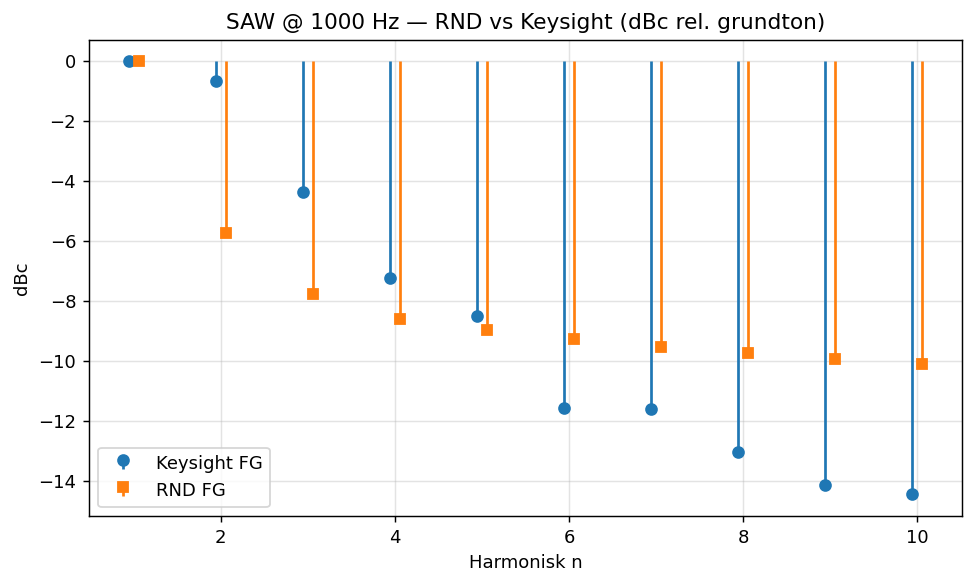

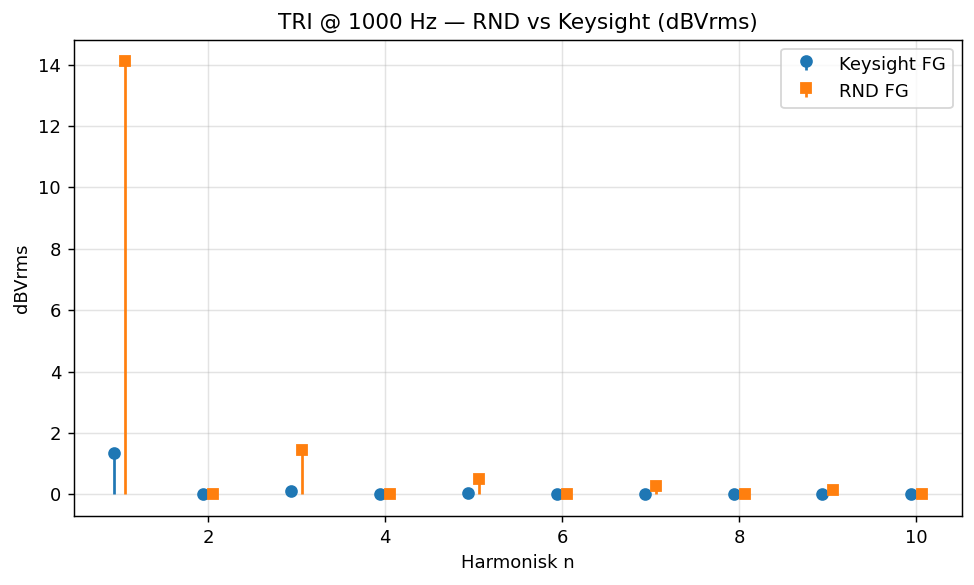

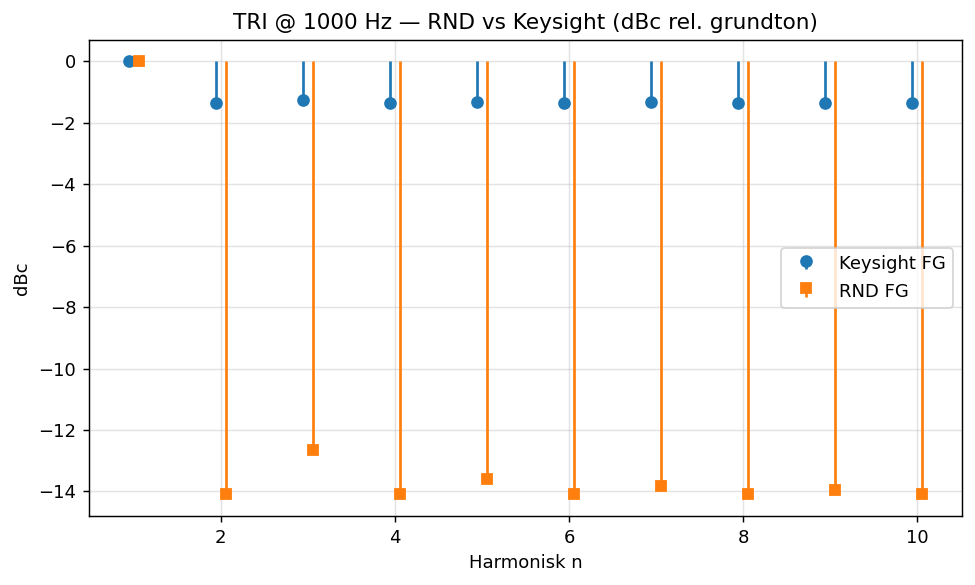

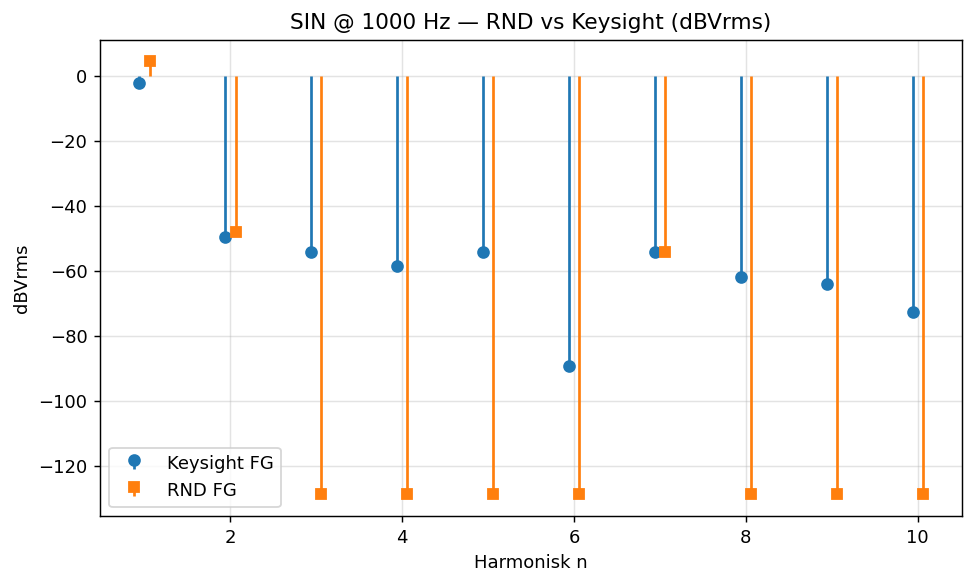

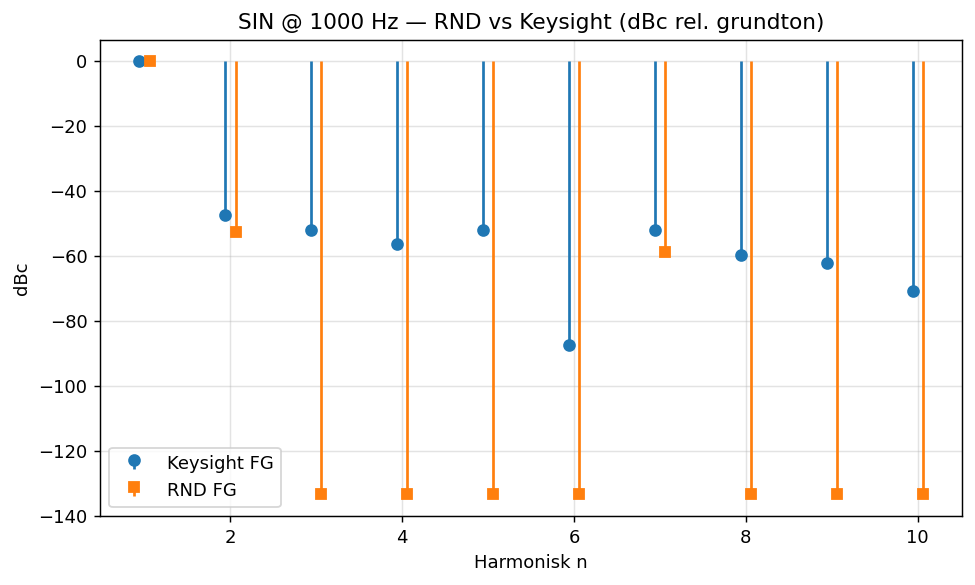


Sammanfattning: RND - Keysight (dB) per vågform


,mean_delta_dB,median_delta_dB,rms_delta_dB,N
waveform,,,,
saw,16.161070,16.604031,16.446100,10
tri,1.494921,0.071776,4.056552,10
sin,-44.020997,-60.461985,54.469578,10


In [253]:
# === RND vs Keysight: robust läsning + dBVrms/dBc-jämförelse per harmonisk ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 130

# ------------------------------------------------------------
# Robust Keysight-CSV reader (semicolon + decimal comma ok)
# Autodetekterar om sista kolumnen redan är dB (många negativa värden)
# och returnerar DataFrame med ['freq','dBVrms'] sorterad och unik.
# ------------------------------------------------------------
def read_scope_fft(csv_path, force_as_dB=None, floor_vrms=1e-12):
    p = Path(csv_path)
    raw = pd.read_csv(p, sep=';', header=None, engine='python', dtype=str)
    freqs, vals = [], []
    for _, row in raw.iterrows():
        nums = []
        for cell in row.dropna():
            s = cell.strip()
            if not s:
                continue
            s = s.replace(',', '.')       # decimal-komma -> punkt
            try:
                nums.append(float(s))
            except ValueError:
                pass
        # Keysight-FFT: sista två numeriska fält brukar vara [freq, amplitude]
        if len(nums) >= 2:
            f, y = nums[-2], nums[-1]
            # Tillåt negativa dB-värden; filtrera bara bort negativa frekvenser
            if f >= 0:
                freqs.append(f)
                vals.append(y)

    if not freqs:
        raise ValueError(f"Inga numeriska datapunkter i {csv_path}")

    df = pd.DataFrame({'freq': freqs, 'Y': vals}).sort_values('freq')
    df = df.drop_duplicates(subset='freq').reset_index(drop=True)

    # Autodetektion av dB: "många" negativa värden -> sannolikt redan dB
    as_dB = bool(force_as_dB) if force_as_dB is not None else False
    if force_as_dB is None:
        y = np.asarray(df['Y'].values, float)
        finite = np.isfinite(y)
        if finite.mean() > 0.9:
            frac_neg = (y[finite] < 0).mean()
            if frac_neg > 0.3:
                as_dB = True

    if as_dB:
        df['dBVrms'] = df['Y'].astype(float)
    else:
        vrms = np.maximum(df['Y'].astype(float), floor_vrms)
        df['dBVrms'] = 20.0*np.log10(vrms)  # Vrms -> dBVrms

    return df[['freq','dBVrms']]

# ------------------------------------------------------------
# Välj närmsta bin kring n*f0 för n=1..N och returnera tabell
# ------------------------------------------------------------
def pick_harmonic_bins(spec_df, f0, n_max):
    f = spec_df['freq'].values
    y = spec_df['dBVrms'].values
    n_all = np.arange(1, n_max+1)
    targets = n_all * f0
    ok = (targets >= f.min()) & (targets <= f.max())
    n = n_all[ok]
    t = targets[ok]

    idx = np.searchsorted(f, t)
    idx = np.clip(idx, 1, len(f)-1)
    # välj närmaste av idx och idx-1
    choose = np.where(np.abs(f[idx]-t) < np.abs(f[idx-1]-t), idx, idx-1)

    return pd.DataFrame({
        'n': n,
        'f_target_Hz': t,
        'f_bin_Hz': f[choose],
        'dBVrms': y[choose],
    })

# ------------------------------------------------------------
# Konvertera serie (dBVrms) till dBc mot grundtonens nivå
# ------------------------------------------------------------
def to_dBc(n, y_dBV):
    n = np.asarray(n)
    y = np.asarray(y_dBV, float)
    # hitta n=1 (grundton)
    if 1 in n:
        ref = y[n.tolist().index(1)]
    else:
        # fallback: ta maxnivån som ref
        ref = np.max(y)
    return y - ref

# ------------------------------------------------------------
# Filnamn (justera vid behov)
# ------------------------------------------------------------
files_keysight = {
    'saw': 'trace_saw_fft.csv',
    'tri': 'trace_triangle_fft.csv',
    'sin': 'trace_sine_fft.csv',
}
files_rnd = {
    'saw': 'RND_lab_saw_fft.csv',
    'tri': 'RND_lab_triangle_fft.csv',
    'sin': 'RND_lab_sine_1khz_fft.csv',
}

# Om du VET vilka som redan är i dB, sätt dem här; annars lämna None för autodetect
force_as_dB_keysight = {'saw': None, 'tri': None, 'sin': None}
force_as_dB_rnd      = {'saw': True,  'tri': True,  'sin': None}   # <- enligt din observation: RND saw/tri var redan dB

F0 = 1000.0     # Hz
N_HARM = 10

all_summaries = []

for wf in ['saw', 'tri', 'sin']:
    try:
        ks_spec = read_scope_fft(files_keysight[wf], force_as_dB_keysight[wf])
        rn_spec = read_scope_fft(files_rnd[wf],      force_as_dB_rnd[wf])
    except Exception as e:
        print(f"[{wf}] hoppade över: {e}")
        continue

    ks_h = pick_harmonic_bins(ks_spec, F0, N_HARM).rename(columns={'dBVrms':'keysight_dBV'})
    rn_h = pick_harmonic_bins(rn_spec, F0, N_HARM).rename(columns={'dBVrms':'rnd_dBV'})

    df = pd.merge(ks_h[['n','keysight_dBV']], rn_h[['n','rnd_dBV']], on='n', how='inner')
    df['delta_dB'] = df['rnd_dBV'] - df['keysight_dBV']

    # --- Plot dBVrms överlägg ---
    plt.figure()
    plt.stem(df['n']-0.06, df['keysight_dBV'], linefmt='C0-', markerfmt='C0o', basefmt=' ')
    plt.stem(df['n']+0.06, df['rnd_dBV'],      linefmt='C1-', markerfmt='C1s', basefmt=' ')
    plt.title(f"{wf.upper()} @ {F0:.0f} Hz — RND vs Keysight (dBVrms)")
    plt.xlabel("Harmonisk n"); plt.ylabel("dBVrms"); plt.grid(alpha=0.35); plt.legend(["Keysight FG","RND FG"])
    plt.tight_layout(); plt.show()

    # --- Plot dBc (form-jämförelse) ---
    dBc_ks = to_dBc(df['n'].values, df['keysight_dBV'].values)
    dBc_rn = to_dBc(df['n'].values, df['rnd_dBV'].values)
    plt.figure()
    plt.stem(df['n']-0.06, dBc_ks, linefmt='C0-', markerfmt='C0o', basefmt=' ')
    plt.stem(df['n']+0.06, dBc_rn, linefmt='C1-', markerfmt='C1s', basefmt=' ')
    plt.title(f"{wf.upper()} @ {F0:.0f} Hz — RND vs Keysight (dBc rel. grundton)")
    plt.xlabel("Harmonisk n"); plt.ylabel("dBc"); plt.grid(alpha=0.35); plt.legend(["Keysight FG","RND FG"])
    plt.tight_layout(); plt.show()

    # --- Summering ---
    vals = df['delta_dB'].dropna().values
    if len(vals):
        all_summaries.append({
            'waveform': wf,
            'mean_delta_dB': float(np.mean(vals)),
            'median_delta_dB': float(np.median(vals)),
            'rms_delta_dB': float(np.sqrt(np.mean(vals**2))),
            'N': int(len(vals)),
        })

# Visa sammanfattningstabell
if all_summaries:
    print("\nSammanfattning: RND - Keysight (dB) per vågform")
    display(pd.DataFrame(all_summaries).set_index('waveform'))
else:
    print("Inga resultat – kontrollera filnamn och sökvägar.")


## 9. RND_lab FG vs Theory (dBVrms)

Here we compare the RND_lab Function Generator spectra against theoretical Fourier amplitudes at 1 kHz for sawtooth, triangle, and sine. We align the FFT bins to n·f0, overlay theory vs measurement, and report per-harmonic error (measured − theory) in dB.


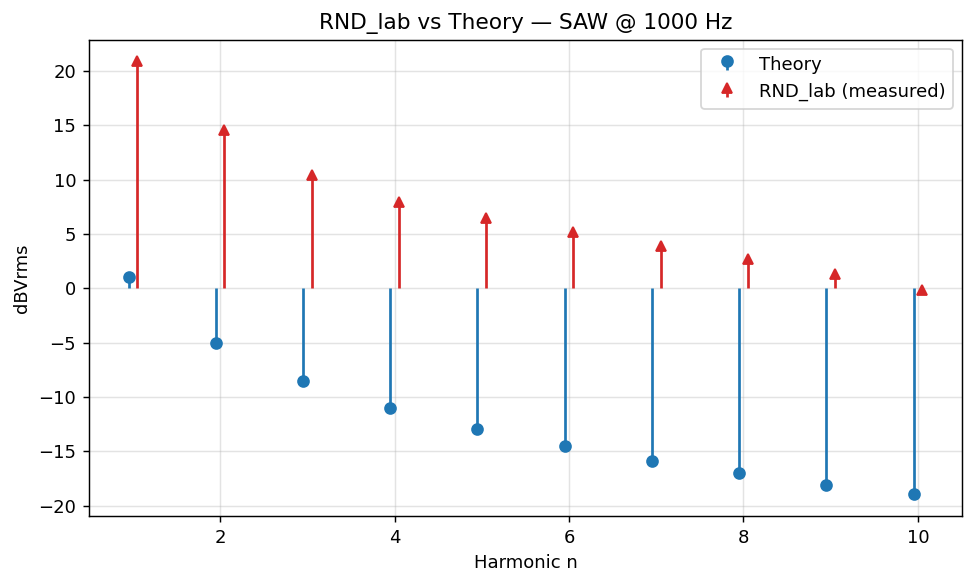

,n,theory_dBVrms,meas_dBVrms,err_dB
0,1,1.026103,20.893918,19.867815
1,2,-4.994497,14.585446,19.579944
2,3,-8.516322,10.474520,18.990843
3,4,-11.015097,7.958796,18.973893
4,5,-12.953297,6.483071,19.436368
5,6,-14.536922,5.230827,19.767749
6,7,-15.875858,3.930511,19.806369
7,8,-17.035697,2.716553,19.752250
8,9,-18.058748,1.304930,19.363678
9,10,-18.973897,-0.119583,18.854314


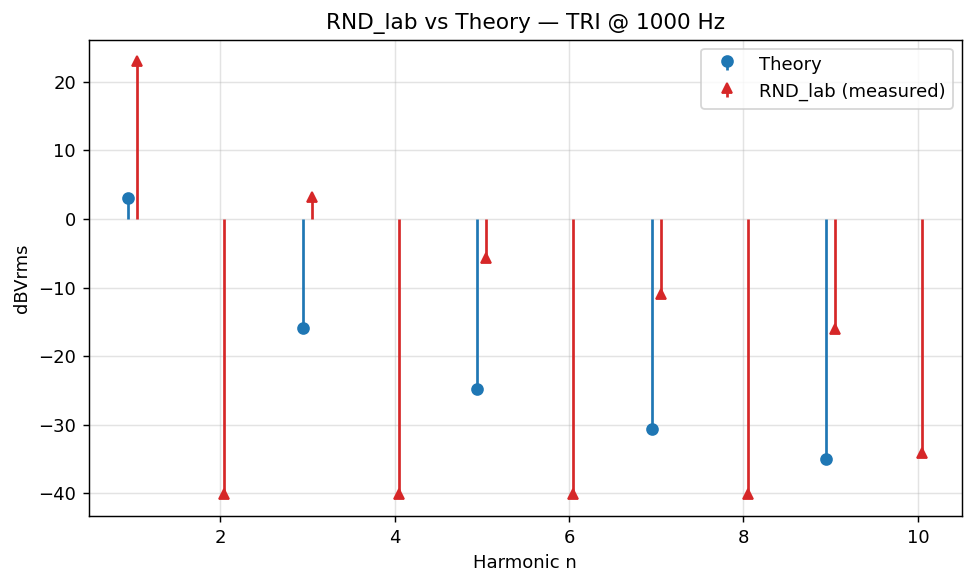

,n,theory_dBVrms,meas_dBVrms,err_dB
0,1,3.124305,22.985345,19.861040
1,2,NaN,-40.207271,NaN
2,3,-15.960545,3.140340,19.100885
3,4,NaN,-40.207271,NaN
4,5,-24.834495,-5.720505,19.113990
5,6,NaN,-40.207271,NaN
6,7,-30.679617,-10.958082,19.721534
7,8,NaN,-40.207271,NaN
8,9,-35.045395,-16.123678,18.921717
9,10,NaN,-34.186035,NaN


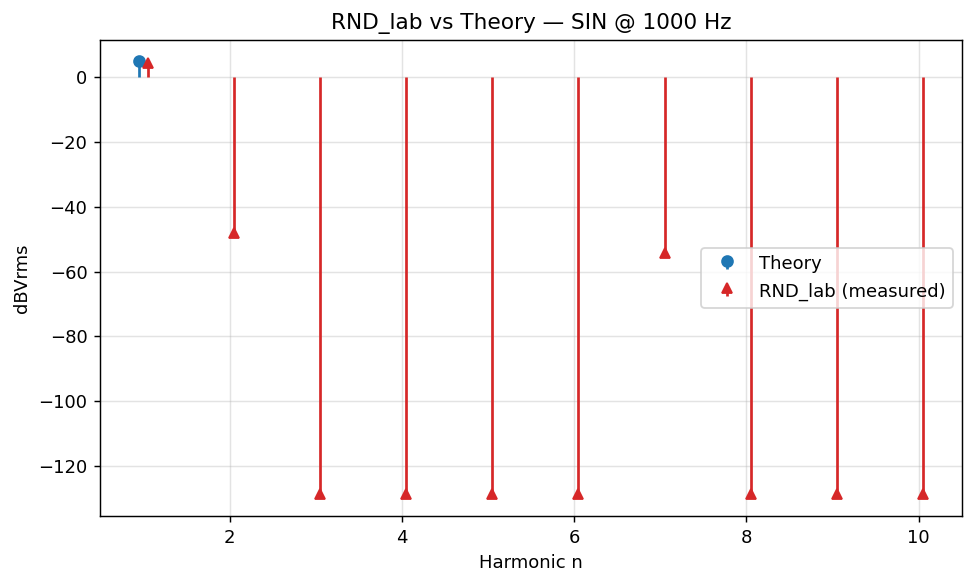

,n,theory_dBVrms,meas_dBVrms,err_dB
0,1,4.9485,4.534818,-0.413683
1,2,NaN,-48.164005,NaN
2,3,NaN,-128.931373,NaN
3,4,NaN,-128.931373,NaN
4,5,NaN,-128.931373,NaN
5,6,NaN,-128.931373,NaN
6,7,NaN,-54.183810,NaN
7,8,NaN,-128.931373,NaN
8,9,NaN,-128.931373,NaN
9,10,NaN,-128.931373,NaN


,mean_err_dB,median_err_dB,rms_err_dB,N
waveform,,,,
saw,19.439322,19.508156,19.442691,10
tri,19.343833,19.113990,19.347453,5
sin,-0.413683,-0.413683,0.413683,1


In [256]:
# RND_lab FG vs Theory at 1 kHz, n=1..10 (dBVrms)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

F0_th = 1000.0
N_th = 10
VPP_th = 5.0  # theoretical assumption used earlier
A_th = VPP_th/2.0

# Reuse helpers if available
try:
    _ = vrms_to_dBVrms  # type: ignore
    _ = read_scope_fft_vrms  # type: ignore
    _ = pick_harmonic_bins  # type: ignore
    _ = theory_dBVrms  # type: ignore
except NameError:
    pass

# Theory generators (use existing ones if defined)
try:
    _ = sawtooth_dBVrms  # type: ignore
    _ = triangle_dBVrms  # type: ignore
    _ = sine_dBVrms  # type: ignore
except NameError:
    def sawtooth_dBVrms(n, A=A_th):
        n = np.asarray(n, int)
        vpk = 2.0*A/(np.pi*np.maximum(n,1))
        vrms = vpk/np.sqrt(2.0)
        return vrms_to_dBVrms(vrms)
    def triangle_dBVrms(n, A=A_th):
        n = np.asarray(n, int)
        vrms = np.zeros_like(n, float)
        odd = (n % 2 == 1)
        vpk_odd = 8.0*A/(np.pi**2 * np.maximum(n[odd],1)**2)
        vrms[odd] = vpk_odd/np.sqrt(2.0)
        dB = vrms_to_dBVrms(vrms); dB[~odd] = np.nan
        return dB
    def sine_dBVrms(n, A=A_th):
        n = np.asarray(n, int)
        vrms = np.zeros_like(n, float)
        vrms[n == 1] = A/np.sqrt(2.0)
        dB = vrms_to_dBVrms(vrms); dB[n != 1] = np.nan
        return dB

def theory_df(waveform, F0=F0_th, N=N_th):
    n = np.arange(1, N+1)
    if waveform == 'saw':
        dB = sawtooth_dBVrms(n, A=A_th)
    elif waveform == 'tri':
        dB = triangle_dBVrms(n, A=A_th)
    elif waveform == 'sin':
        dB = sine_dBVrms(n, A=A_th)
    else:
        raise ValueError
    return pd.DataFrame({'n': n, 'f_Hz': n*F0, 'theory_dBVrms': dB})

files_rnd = {
    'saw': 'RND_lab_saw_fft.csv',
    'tri': 'RND_lab_triangle_fft.csv',
    'sin': 'RND_lab_sine_1khz_fft.csv',
}

res = {}
for wf in ['saw', 'tri', 'sin']:
    try:
        spec = read_scope_fft_vrms(files_rnd[wf])
    except Exception as e:
        print(f"Skipping {wf}: {e}")
        continue
    meas = pick_harmonic_bins(spec, F0_th, N_th)
    # Harmonize column name from different pick_harmonic_bins versions
    if 'meas_dBVrms' not in meas.columns and 'dBVrms' in meas.columns:
        meas = meas.rename(columns={'dBVrms': 'meas_dBVrms'})
    theo = theory_df(wf, F0=F0_th, N=N_th)
    df = meas.merge(theo, on='n', how='left')
    df['err_dB'] = df['meas_dBVrms'] - df['theory_dBVrms']
    res[wf] = df

    # Plot overlay
    plt.figure()
    plt.stem(df['n']-0.05, df['theory_dBVrms'], linefmt='C0-', markerfmt='C0o', basefmt=' ', label='Theory')
    plt.stem(df['n']+0.05, df['meas_dBVrms'],   linefmt='C3-', markerfmt='C3^', basefmt=' ', label='RND_lab (measured)')
    plt.title(f"RND_lab vs Theory — {wf.upper()} @ {F0_th:.0f} Hz")
    plt.xlabel('Harmonic n'); plt.ylabel('dBVrms'); plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout(); plt.show()

    # Table of errors
    display(df[['n','theory_dBVrms','meas_dBVrms','err_dB']])

# Summary
if res:
    summary = []
    for wf, d in res.items():
        vals = d['err_dB'].dropna().values
        if len(vals):
            summary.append({
                'waveform': wf,
                'mean_err_dB': float(np.mean(vals)),
                'median_err_dB': float(np.median(vals)),
                'rms_err_dB': float(np.sqrt(np.mean(vals**2))),
                'N': int(len(vals)),
            })
    if summary:
        display(pd.DataFrame(summary).set_index('waveform'))
else:
    print('No results to summarize — check file names.')


## 10. Summary table: Keysight measurements vs Theory (4 signals)

This table aggregates per-harmonic amplitudes (dBVrms) for the four measured cases and their theoretical counterparts at 1 kHz:
- Sawtooth (input)
- Triangle (input)
- Sine (input)
- Sawtooth after RC (output)

For each harmonic n=1..10, it lists measurement and theory plus the error in dB (measured − theory). Only harmonics defined by theory are compared (e.g., triangle even n are NaN).


In [257]:
# Build a unified comparison table: Keysight measured vs Theory (dBVrms)
import numpy as np
import pandas as pd
from IPython.display import display

F0_tbl = 1000.0
N_tbl = 10

# Reuse helpers from earlier cells

signals = [
    {
        'name': 'saw_in',
        'csv': 'trace_saw_fft.csv',
        'waveform': 'saw',
        'apply_rc': False,
        'title': 'Sawtooth (in)'
    },
    {
        'name': 'tri_in',
        'csv': 'trace_triangle_fft.csv',
        'waveform': 'tri',
        'apply_rc': False,
        'title': 'Triangle (in)'
    },
    {
        'name': 'sin_in',
        'csv': 'trace_sine_fft.csv',
        'waveform': 'sin',
        'apply_rc': False,
        'title': 'Sine (in)'
    },
    {
        'name': 'saw_after_rc',
        'csv': 'rc_fft_1khz.csv',
        'waveform': 'saw',
        'apply_rc': True,
        'title': 'Sawtooth (after RC)'
    },
]

rows = []
for sig in signals:
    try:
        spec = read_scope_fft_vrms(sig['csv'])
    except Exception as e:
        print(f"Skip {sig['name']}: {e}")
        continue
    meas = pick_harmonic_bins(spec, F0_tbl, N_tbl)
    # Harmonize column names from different helper versions
    if 'meas_dBVrms' not in meas.columns and 'dBVrms' in meas.columns:
        meas = meas.rename(columns={'dBVrms': 'meas_dBVrms'})
    theo = theory_dBVrms(F0=F0_tbl, N=N_tbl, waveform=sig['waveform'], apply_rc=sig['apply_rc'])
    df = meas.merge(theo, on='n', how='left')
    df['err_dB'] = df['meas_dBVrms'] - df['theory_dBVrms']
    df['signal'] = sig['title']
    rows.append(df[['signal','n','f_Hz','meas_dBVrms','theory_dBVrms','err_dB']])

if rows:
    table = pd.concat(rows, ignore_index=True)
    # Order columns nicely and sort
    table = table[['signal','n','f_Hz','meas_dBVrms','theory_dBVrms','err_dB']]
    table = table.sort_values(['signal','n']).reset_index(drop=True)
    display(table)

    # Optional: Pivot view for compactness (one row per n)
    pivot_cols = []
    for sig in [s['title'] for s in signals]:
        for what in ['meas','theo','err']:
            pivot_cols.append(f"{sig} {what}")
    # build a multi-metric pivot by joining three pivots side by side
    piv_meas = table.pivot(index='n', columns='signal', values='meas_dBVrms')
    piv_theo = table.pivot(index='n', columns='signal', values='theory_dBVrms')
    piv_err  = table.pivot(index='n', columns='signal', values='err_dB')
    # Flatten with prefixed column names
    piv_meas.columns = [f"{c} meas" for c in piv_meas.columns]
    piv_theo.columns = [f"{c} theo" for c in piv_theo.columns]
    piv_err.columns  = [f"{c} err"  for c in piv_err.columns]
    piv_all = pd.concat([piv_meas, piv_theo, piv_err], axis=1)
    # Keep a stable column order
    ordered = []
    for sig in [s['title'] for s in signals]:
        ordered += [f"{sig} meas", f"{sig} theo", f"{sig} err"]
    piv_all = piv_all.reindex(columns=[c for c in ordered if c in piv_all.columns])
    display(piv_all)
else:
    print('No rows generated — verify CSV paths exist.')


,signal,n,f_Hz,meas_dBVrms,theory_dBVrms,err_dB
0,Sawtooth (after RC),1,1000.0,-0.417003,0.003643,-0.420646
1,Sawtooth (after RC),2,2000.0,-9.055858,-8.136987,-0.918872
2,Sawtooth (after RC),3,3000.0,-13.886599,-13.817135,-0.069463
3,Sawtooth (after RC),4,4000.0,-18.198600,-18.214411,0.015812
4,Sawtooth (after RC),5,5000.0,-22.476204,-21.782140,-0.694065
5,Sawtooth (after RC),6,6000.0,-25.088529,-24.772041,-0.316488
6,Sawtooth (after RC),7,7000.0,-27.336981,-27.339369,0.002388
7,Sawtooth (after RC),8,8000.0,-29.835767,-29.585763,-0.250004
8,Sawtooth (after RC),9,9000.0,-32.601840,-31.580898,-1.020942
9,Sawtooth (after RC),10,10000.0,-33.761688,-33.374370,-0.387317


,Sawtooth (in) meas,Sawtooth (in) theo,Sawtooth (in) err,Triangle (in) meas,Triangle (in) theo,Triangle (in) err,Sine (in) meas,Sine (in) theo,Sine (in) err,Sawtooth (after RC) meas,Sawtooth (after RC) theo,Sawtooth (after RC) err
n,,,,,,,,,,,,
1,-4.482333,1.026103,-5.508436,2.641790,3.124305,-0.482515,-2.102663,4.9485,-7.051163,-0.417003,0.003643,-0.420646
2,-5.122092,-4.994497,-0.127595,-50.664103,NaN,NaN,-49.487646,NaN,NaN,-9.055858,-8.136987,-0.918872
3,-8.846661,-8.516322,-0.330339,-20.034010,-15.960545,-4.073465,-54.035016,NaN,NaN,-13.886599,-13.817135,-0.069463
4,-11.708367,-11.015097,-0.693269,-38.622506,NaN,NaN,-58.373162,NaN,NaN,-18.198600,-18.214411,0.015812
5,-12.986561,-12.953297,-0.033264,-26.950876,-24.834495,-2.116381,-54.035016,NaN,NaN,-22.476204,-21.782140,-0.694065
6,-16.037172,-14.536922,-1.500249,-60.207589,NaN,NaN,-89.342330,NaN,NaN,-25.088529,-24.772041,-0.316488
7,-16.069481,-15.875858,-0.193623,-30.663626,-30.679617,0.015991,-54.035016,NaN,NaN,-27.336981,-27.339369,0.002388
8,-17.509711,-17.035697,-0.474014,-60.207589,NaN,NaN,-61.773012,NaN,NaN,-29.835767,-29.585763,-0.250004
9,-18.607909,-18.058748,-0.549161,-37.927253,-35.045395,-2.881858,-64.151500,NaN,NaN,-32.601840,-31.580898,-1.020942
